# Preparation

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [133]:
pneumonia_images = []
healthy_images = []
import os
import struct
import numpy as np
import glob
import cv2
images = glob.glob("chest_xray/test/NORMAL/*")
for image in images:
    im = cv2.imread(image,0)
    im = cv2.resize(im,(200,200))
    im = im.flatten()/255 -.5
    healthy_images.append(im)
images = glob.glob("chest_xray/test/PNEUMONIA/*")
for image in images:
    im = cv2.imread(image,0)
    im = cv2.resize(im,(200,200))
    im = im.flatten()/255 -.5
    pneumonia_images.append(im)


In [134]:
#Now lets put them together with y values
healthy_images
b = np.zeros((len(healthy_images),1))
a = np.ones((len(pneumonia_images),1))
healthy_images = np.hstack((healthy_images, b))
pneumonia_images = np.hstack((pneumonia_images, a))
images = np.vstack([healthy_images, pneumonia_images])

In [135]:
y = images[:,-1]
X = images[:,:-1]

# folding below
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
img_wh = 200
y_test_ohe = keras.utils.to_categorical(y_test, 2)
y_train_ohe = keras.utils.to_categorical(y_train, 2)
X_train_img = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test_img = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
folds = StratifiedKFold(n_splits=5,random_state=1).split(X_train, y_train)

# Modeling

In [136]:

#this is expansion on the dataset. This is a slower way to do it. When we use a keras generator we call .fit on a python generator
#this will yield batches

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False, #do we want to make it 0 mean
    featurewise_std_normalization=False, #do we take the whole batch and make it 0 mean, no
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations. Randomly rotate images 5 degrees 
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts. 
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False, 
    rescale=None) #this generator will esentially run forever. This will manipulate our data, will give us different datasets every time


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)
#Instantiate an empty model
#get a bigger dataset
mlp_model = Sequential()
mlp_model.add(Dense(100, input_shape=(200,200,1)))
mlp_model.add(Activation('relu'))

mlp_model.add(Dropout(0.25))
mlp_model.add(Dense(32))
mlp_model.add(Activation('relu'))
# Add Dropout
mlp_model.add(Dropout(0.25))

# Output Layer
mlp_model.add(Flatten())
mlp_model.add(Dense(2))
mlp_model.add(Activation('softmax'))
mlp_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200, 200, 100)     200       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 100)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 100)     0         
_________________________________________________________________
dense_2 (Dense)              (None, 200, 200, 32)      3232      
_________________________________________________________________
activation_2 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280000)          

In [9]:
scores = []
from keras.callbacks import CSVLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#csv_logger = CSVLogger('alexNet_log.csv', append=True, separator=';')
mlp_histories= []
mlp_y_preds = []
mlp_fprs = []
mlp_tprs = []
mlp_aucs = []
histories = []
mlp_thresholds = []
#datagen.fit(X_train)
for k, (train, test) in enumerate(folds):
    mlp_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=[keras.metrics.Recall()])
    print("new fold")
    datagen.fit(X_train_img)
    mlp_histories.append(mlp_model.fit_generator(datagen.flow(X_train_img[train], y_train_ohe[train], batch_size=32),
             steps_per_epoch=int(len(X_train)/2),
             epochs=10, verbose=1,
             validation_data=(X_test_img,y_test_ohe),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)]# no early stopping to allow for roc curve avg. across folds
             ))
    y_pred_keras = mlp_model.predict(X_test_img).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_ohe.ravel(), y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    mlp_aucs.append(auc_keras)
    mlp_fprs.append(fpr_keras)
    mlp_y_preds.append(y_pred_keras)
    mlp_tprs.append(tpr_keras)
    mlp_thresholds.append(thresholds_keras)


new fold
Epoch 1/10
249/249 [==============================] - 479s 2s/step - loss: 0.4168 - recall_3: 0.8169 - val_loss: 0.2989 - val_recall_3: 0.8560
Epoch 2/10
249/249 [==============================] - 476s 2s/step - loss: 0.2963 - recall_3: 0.8729 - val_loss: 0.2732 - val_recall_3: 0.8800
Epoch 3/10
249/249 [==============================] - 475s 2s/step - loss: 0.2637 - recall_3: 0.8867 - val_loss: 0.2646 - val_recall_3: 0.8800
Epoch 4/10
249/249 [==============================] - 475s 2s/step - loss: 0.2506 - recall_3: 0.8925 - val_loss: 0.2579 - val_recall_3: 0.8800
Epoch 5/10
249/249 [==============================] - 477s 2s/step - loss: 0.2507 - recall_3: 0.8931 - val_loss: 0.1951 - val_recall_3: 0.9280
Epoch 6/10
249/249 [==============================] - 473s 2s/step - loss: 0.2383 - recall_3: 0.9050 - val_loss: 0.2958 - val_recall_3: 0.8720
Epoch 7/10
249/249 [==============================] - 474s 2s/step - loss: 0.2376 - recall_3: 0.9049 - val_loss: 0.2186 - val_recall_

In [137]:
def get_model(kernel_size):
    np.random.seed(1000)
    #Instantiate an empty model
    #get a bigger dataset
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=(200,200,1), kernel_size=(kernel_size,kernel_size),  padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', data_format="channels_last"))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid',  data_format="channels_last"))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', data_format="channels_last"))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', data_format="channels_last"))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.summary()

    # Compile the model
    return model

In [138]:
scores = []
from keras.callbacks import CSVLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
csv_logger = CSVLogger('alexNet_log.csv', append=True, separator=';')
histories= []
y_preds = []
fprs = []
tprs = []
aucs = []
thresholds = []
model = get_model(7)
#datagen.fit(X_train)
print(folds)
for k, (train, test) in enumerate(folds):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=[keras.metrics.Recall()])
    print("new fold")
    datagen.fit(X_train_img)
    histories.append(model.fit_generator(datagen.flow(X_train_img[train], y_train_ohe[train], batch_size=32),
             steps_per_epoch=int(len(X_train)/2),
             epochs=10, verbose=1,
             validation_data=(X_test_img,y_test_ohe),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)] #no early stopping to allow for roc curve avg. across folds
             ))
    y_pred_keras = model.predict(X_test_img).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_ohe.ravel(), y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    aucs.append(auc_keras)
    fprs.append(fpr_keras)
    y_preds.append(y_pred_keras)
    tprs.append(tpr_keras)
    mlp_thresholds.append(thresholds_keras)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 194, 194, 32)      1600      
_________________________________________________________________
activation_112 (Activation)  (None, 194, 194, 32)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 91, 91, 64)        100416    
_________________________________________________________________
activation_113 (Activation)  (None, 91, 91, 64)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 43, 43, 128)     

KeyboardInterrupt: 

In [147]:
recalls = np.array([list(v for k,v in history.history.items() if k.startswith('recall')) for history in histories])
val_recalls = np.array([list(v for k,v in history.history.items() if k.startswith('val_recall')) for history in histories])

NameError: name 'val_recalls' is not defined

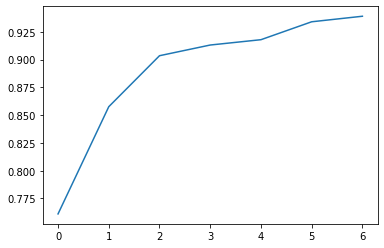

In [5]:
#Start here if you want visualization from the pickle files
for fold in range(len(recalls)):
    plt.figure(fold+1)
    epochs =  [i for i in range(len(recalls[fold][0]))]
    plt.plot( epochs, recalls[fold][0], label='Training set')
    plt.plot( epochs, val_recalls[fold][0], label='Testing set')
    plt.xlabel('epoch')
    plt.ylabel('Recall score')
    plt.title('Recall score for fold {}'.format(fold+1))
    plt.legend()
    plt.show()
        

The biggest thing that stands out to me is how epoch 1 had such a lower starting recall score. I always thought that every time you call `.compile` the model starts over. That does not appear to be true. However, we are still achieveing great recall scores on the training set. It does appear that almost are alwasys overfitting by the end of each fold. I believe this is due to a lack of images. Maybe we could prevent this in the future by having a greater variety of images?

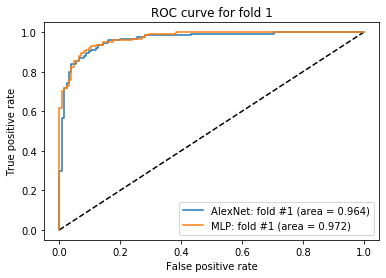

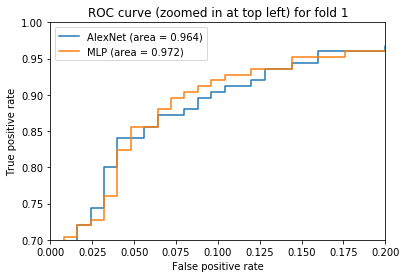

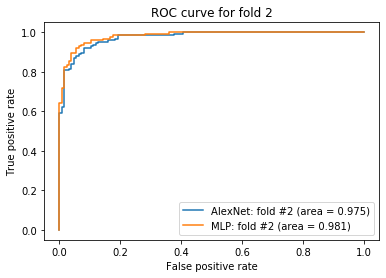

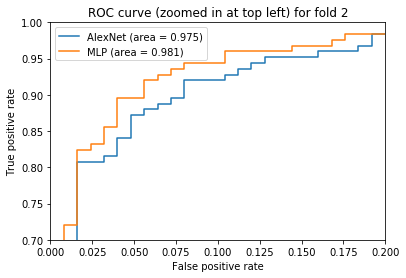

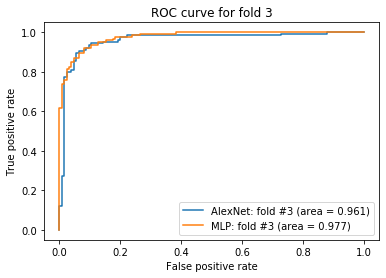

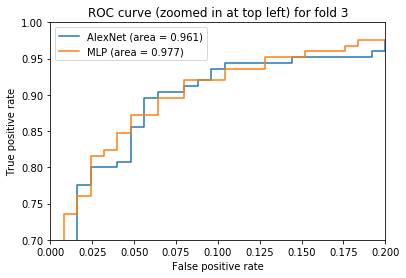

<Figure size 432x288 with 0 Axes>

In [119]:
#THIS CODE WAS ADAPTED FROM THIS SOURCE https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
plt.plot([0, 1], [0, 1], 'k--')
counter = 0
for index in range(len(aucs)):
    plt.figure(counter+1)
    if index < len(aucs) and index < len(mlp_aucs):
        plt.plot(fprs[index], tprs[index], label='AlexNet: fold #{} (area = {:.3f})'.format(index+1 ,aucs[index]))
        plt.plot(mlp_fprs[index], mlp_tprs[index], label='MLP: fold #{} (area = {:.3f})'.format(index+1, mlp_aucs[index], index))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for fold {}'.format(index+1))
        plt.legend(loc='best')
        plt.show()
        counter += 1
        plt.figure(counter+1)
        plt.xlim(0, 0.2)
        plt.ylim(0.7, 1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fprs[index], tprs[index], label='AlexNet (area = {:.3f})'.format(aucs[index]))
        plt.plot(mlp_fprs[index], mlp_tprs[index], label='MLP (area = {:.3f})'.format(mlp_aucs[index]))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (zoomed in at top left) for fold {}'.format(index+1))
        plt.legend(loc='best')
        plt.show()
        counter += 1

In [120]:
print("What is the average AOC for each of our folds?")
print("Average for AlexNet: {:.3}, Average for MLP: {:.3}".format(np.mean(aucs), np.mean(mlp_aucs)))

What is the average AOC for each of our folds?
Average for AlexNet: 0.96, Average for MLP: 0.977


It looks like the performance of alexnet and the MLP perform simlarly on this dataset, with the MLP having the edge only slightly. This looks like it is mainly because of the better true positive rate at extremely low false positive rates. When we are reaching TPR scores that matter much more (95-99)% they appear to perform about the same. The average AOC for the MLP and AlexNet has the MLP performing slightly better overall, but as I pointed out earlier, that looks to be because of the lower false positive rate at low true positive rates.

In [148]:
import pickle
### ONLY RUN THIS TO OVERWRITE WHAT IS IN THE CURRENT PICKLES
#Now lets save our items to a file 
#mlp_fprs, mlp_tprs, mlp_aucs, fprs, tprs, aucs, recalls
# with open('mlp_fprs.pickle', 'wb') as handle:
#     pickle.dump(mlp_fprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('mlp_tprs.pickle', 'wb') as handle:
#     pickle.dump(mlp_tprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('mlp_aucs.pickle', 'wb') as handle:
#     pickle.dump(mlp_aucs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('fprs.pickle', 'wb') as handle:
#     pickle.dump(fprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('tprs.pickle', 'wb') as handle:
#     pickle.dump(tprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('aucs.pickle', 'wb') as handle:
#     pickle.dump(aucs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('recalls.pickle', 'wb') as handle:
#     pickle.dump(recalls, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('val_recalls.pickle', 'wb') as handle:
#     pickle.dump(val_recalls, handle, protocol=pickle.HIGHEST_PROTOCOL)
#Writing kernel size 7 files
# with open('sev_fprs.pickle', 'wb') as handle:
#     pickle.dump(sev_fprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sev_tprs.pickle', 'wb') as handle:
#     pickle.dump(sev_tprs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sev_aucs.pickle', 'wb') as handle:
#     pickle.dump(sev_aucs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sev_recalls.pickle', 'wb') as handle:
#     pickle.dump(sev_recalls, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sev_val_recalls.pickle', 'wb') as handle:
#     pickle.dump(sev_val_recalls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
import pickle
#RUN THIS FOR READING FROM A FILE

with open('mlp_fprs.pickle', 'rb') as handle:
    mlp_fprs = (pickle.load(handle))
with open('mlp_tprs.pickle', 'rb') as handle:
    mlp_tprs = (pickle.load(handle))
with open('mlp_aucs.pickle', 'rb') as handle:
    mlp_aucs = (pickle.load(handle))
with open('fprs.pickle', 'rb') as handle:
    fprs = (pickle.load(handle))
with open('tprs.pickle', 'rb') as handle:
    tprs = (pickle.load(handle))
with open('aucs.pickle', 'rb') as handle:
    aucs = (pickle.load(handle))
with open('recalls.pickle', 'rb') as handle:
    recalls = (pickle.load(handle))
with open('sev_fprs.pickle', 'rb') as handle:
    sev_fprs = (pickle.load(handle))
with open('sev_tprs.pickle', 'rb') as handle:
    sev_tprs = (pickle.load(handle))
with open('sev_aucs.pickle', 'rb') as handle:
    sev_aucs = (pickle.load(handle))
with open('sev_recalls.pickle', 'rb') as handle:
    sev_recalls = (pickle.load(handle))
with open('sev_val_recalls.pickle', 'rb') as handle:
    sev_val_recalls = (pickle.load(handle))

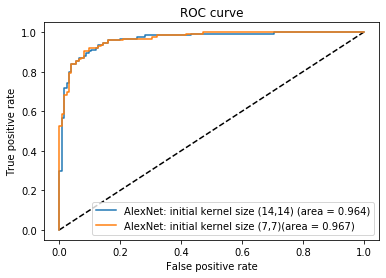

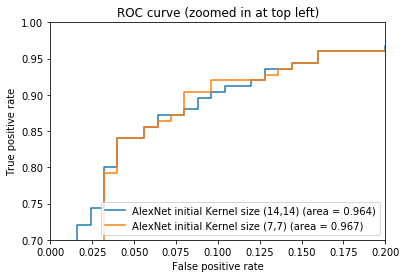

In [4]:
#Lets compare our sev recall values with our 14 recall values
plt.plot([0, 1], [0, 1], 'k--')
plt.figure(1)
plt.plot(fprs[0], tprs[0], label='AlexNet: initial kernel size (14,14) (area = {:.3f})'.format(aucs[0]))
plt.plot(sev_fprs[0], sev_tprs[0], label='AlexNet: initial kernel size (7,7)(area = {:.3f})'.format(sev_aucs[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fprs[0], tprs[0], label='AlexNet initial Kernel size (14,14) (area = {:.3f})'.format(aucs[0]))
plt.plot(sev_fprs[0], sev_tprs[0], label='AlexNet initial Kernel size (7,7) (area = {:.3f})'.format(sev_aucs[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Here we can see that starting our initial CONV2D layer with a kernel size of (7,7) compared to (14,14) shows not much of an improvement in the overall AUC for AlexNet. I expected to see one outperform the other by more than .003 AUC. This shows that for this dataset, it is likely that kernel size of the initial layer does not affect the overall AUC for AlexNet from shapes (7,7) to (14,14)